In [1]:
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/winke/opt/anaconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# United Kingdom

In [2]:
#Load in data
#Import csv and remove non-numerical variables
df = pd.read_csv('weekly_new.csv')
df = df.drop(['name', 'year', 'week', 'latitude', 'longitude', 'espg'] , axis=1)

df = df[['counts_week', 'country', 'dist_to_greenspace', 'dist_to_edu', 'bike_points', 'bus_stops', 'business_shops', 'traffic_signals', 'cycle_length', 'dem_std',
         'lst_mean', 'pop_sum', 'build_area', 'ndvi_mean', 'dist_to_bikePOI', 'dist_to_train', '3_way_int_count', 'median_speed', 'orientation_entropy']]

country = df[df['country'] == 'UK']

#Create dependent and independent variable
y = country.loc[:,'counts_week']
X = country.drop(['counts_week', 'country'], axis=1)

# Normalize dependent variable
scaler = StandardScaler()
data_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
y = pd.Series(data_scaled.ravel())

In [3]:
#Create traintestsplit for machine learning models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

## Linear Regression (OLS)

In [4]:
#Add a constant to the data and run OLS regression
Xc = sm.add_constant(X)
Xc.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
model = sm.OLS(y, Xc).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     18.04
Date:                Sun, 19 Feb 2023   Prob (F-statistic):           1.87e-36
Time:                        14:20:45   Log-Likelihood:                -336.60
No. Observations:                 316   AIC:                             709.2
Df Residuals:                     298   BIC:                             776.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.9592    

In [5]:
# Predict target variable using the OLS model
y_pred = model.predict(Xc)

# Calculate evaluation metrics
mse = mean_squared_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
mae = mean_absolute_error(y, y_pred)

# Print evaluation metrics
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  0.492876122548309
RMSE:  0.7020513674570465
MAE:  0.43920335379241765


In [23]:
Xnc = Xc.drop('const', axis=1)

#Check multicolinearity with VIF
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(Xnc.values, i) for i in range(Xnc.shape[1])]
vif["features"] = Xnc.columns

print(vif)

           VIF              features
0     3.230577              dem_mean
1     4.025645          cycle_length
2    16.178123              lst_mean
3     5.957799               pop_sum
4     4.533486               dem_std
5    13.260465            build_area
6    22.571950   street_length_total
7    18.072460             ndvi_mean
8     4.921063           restaurants
9     3.019283       dist_to_bikePOI
10   17.632002       3_way_int_count
11    4.116422           bike_points
12    4.136551           daily_shops
13    6.998290          median_speed
14    2.852930        business_shops
15    3.636297       traffic_signals
16    4.220737           dist_to_edu
17    3.564103         dist_to_train
18  102.803929  streets_per_node_avg
19   95.957475          circuity_avg
20   55.568380            lc_entropy
21    4.419665             bus_stops
22    3.579338    dist_to_greenspace


## Random Forest

In [6]:
# Define the parameter grid to search
param_grid = {'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [5, 10, 15, 20, 25],
            'min_samples_split': [2, 5, 10]}

# Create the random forest model
rf = RandomForestRegressor()

# Create the K-fold cross-validation object
kf = KFold(n_splits=5)

# Create the grid search object
grid_search = GridSearchCV(rf, param_grid, cv=kf, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

#Create model from best parameters
best_params = grid_search.best_params_
model_rf = RandomForestRegressor(**best_params)

#Run the model on the test split of the data
model_rf.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

#Calculate model statistics and print them
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared: ", r2)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

Best parameters:  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Best score:  -0.5946530858973814
R-squared:  0.329343445005017
MSE:  0.9803683543657012
RMSE:  0.9901355232318964
MAE:  0.3702335179158962


Select which shap graph you would like to see using commenting

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


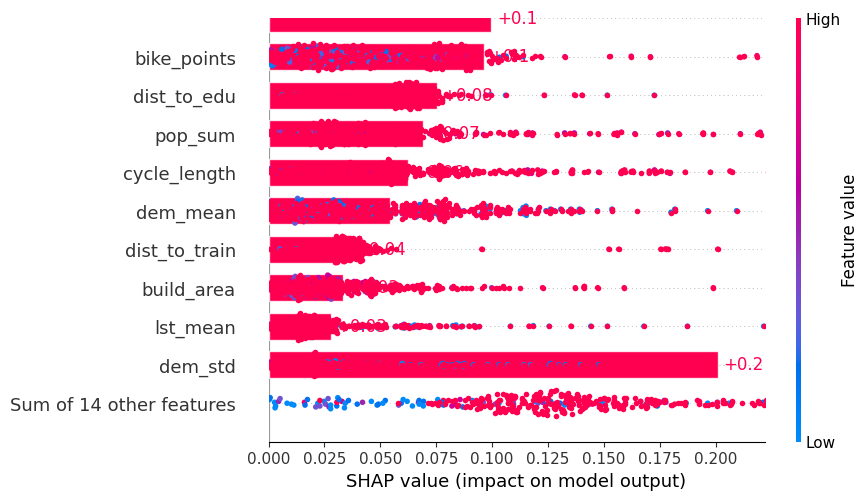

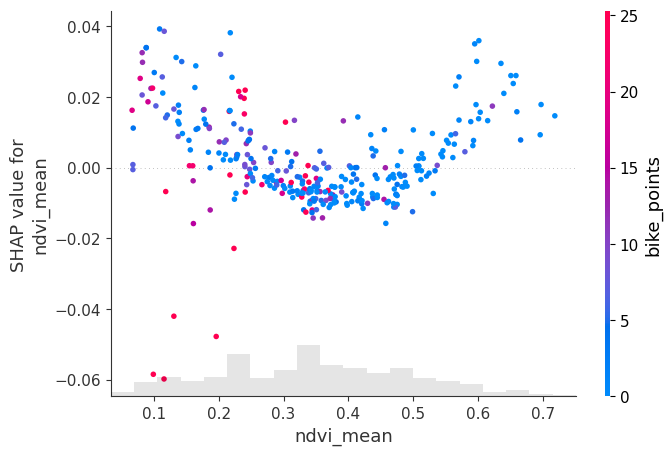

In [6]:
#Using SHAP to explain things
explainer = shap.Explainer(model_rf, X_train)
shap_values = explainer(X)

# shap_values.display_data = shap.datasets.adult(display=True)[0].values
shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)

shap.plots.beeswarm(shap_values.abs, color="shap_red")

shap.plots.scatter(shap_values[:,"ndvi_mean"], color=shap_values)


## XGBoost

In [10]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold

# Define the parameter grid to search
param_grid = {'n_estimators': [50, 100, 200, 250, 300, 400],
              'max_depth': [3, 5, 10, 15],
              'learning_rate': [0.1, 0.3, 0.5, 1],
              'subsample': [0.8, 1],
              'colsample_bytree': [0.8, 1]
              }

# Create the XGBoost model
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror')

# Create the K-fold cross-validation object
kf = KFold(n_splits=5)

# Create the grid search object
grid_search = GridSearchCV(xgb_reg,
                param_grid=param_grid,
                cv=kf,
                scoring='neg_mean_squared_error',
                verbose=True)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

#Create model from best parameters
best_params = grid_search.best_params_
model_xgb = xgb.XGBRegressor(**best_params)

# Get the predictions of the model on the test data
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

# Calculate the R-squared, RMSE, MSE and F1-score
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared: ", r2)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best parameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best score:  -8771588.755647812
R-squared:  0.39895575442759923
MSE:  14563618.326905621
RMSE:  3816.230905868462
MAE:  1384.6444659233093


Select which shap graph you would like to see using commenting

In [ ]:
#Using SHAP to explain things
explainer = shap.Explainer(model_xgb, X_train)
shap_values = explainer(X)

# shap_values.display_data = shap.datasets.adult(display=True)[0].values
shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)

shap.plots.beeswarm(shap_values.abs, color="shap_red")

shap.plots.bar(shap_values[1])

shap.plots.scatter(shap_values[:,"ndvi_mean"], color=shap_values)

## SVM

In [11]:
# Define the parameter grid to search
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1],
              'kernel': ['linear', 'rbf']
              }

# Create the SVM model
svm_reg = SVR()

# Create the K-fold cross-validation object
kf = KFold(n_splits=5)

# Create the grid search object
grid_search = GridSearchCV(svm_reg,
                param_grid=param_grid,
                cv=kf,
                scoring='neg_mean_squared_error',
                verbose=True)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

#Create model from best parameters
best_params = grid_search.best_params_
model_svm = SVR(**best_params)

# Get the predictions of the model on the test data
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)

# Calculate the R-squared, RMSE, MSE and F1-score
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared: ", r2)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters:  {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Best score:  -0.6488648774259547
R-squared:  0.39950083129216685
MSE:  0.8778120148672429
RMSE:  0.9369162261735267
MAE:  0.538897257800182


Select which shap graph you would like to see using commenting

In [ ]:
#Using SHAP to explain things
explainer = shap.Explainer(model_svm, X_train)
shap_values = explainer(X)

# shap_values.display_data = shap.datasets.adult(display=True)[0].values
shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)

shap.plots.beeswarm(shap_values.abs, color="shap_red")

shap.plots.bar(shap_values[1])

shap.plots.scatter(shap_values[:,"ndvi_mean"], color=shap_values)